<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 507 ms, sys: 1.83 s, total: 2.34 s
Wall time: 4.64 s


In [3]:
captions[15]

['a flower vase is sitting on a porch stand .',
 'white vase with different colored flowers sitting inside of it .',
 'a white vase with many flowers on a stage',
 'a white vase filled with different colored flowers .',
 'a vase with red and white flowers outside on a sunny day .']

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [2]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [3]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for capt in captions:
    for sent in capt:
        for word in sent:
            word_counts[word] += 1

In [4]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

На основе имеющегося в изначальном варианте словаря постараемся построить словарь, используя алгоритм BPE. Предполагается, что в таком словаре мы не отбрасываем наименее частотные слова, т.е. не теряем информацию.
Вместо словаря из слов мы начинаем словарём из букв, считая пробел также символом. Далее, согласно алгоритму, мы наиболее частотную биграмму "слов" (в нашем случае, на первой итерации, букв) объединяем в новое слово, подсчитываем её частоту, уменьшаем частоту повторений слов, из которых мы её образовали. Алгоритм можно повторять итеративно до того размера словаря, который требуется. 
Я расширил словарь bpe до того же размера, каким получился исходный словарь. Однако, возможно, стоило сделать ограничение по частоте, а не по размеру словаря, то есть, остановить процесс в тот момент, когда частота нового добавляемого слова составляла меньше 5.

In [212]:
#Проход по исходному словарю, подсчёт всех букв в датасете (наших новых слов)
captions_for_bpe = []
bpe_word_counts = Counter()
for capt in captions:
    capt_bce = []
    for sent in capt:
        new_sent = []
        for word in sent:
            try:
                word.index('#')
                new_sent.append(word)
            except:
                for letter in word:
                    new_sent.append(letter)
                    bpe_word_counts[letter] += 1
                new_sent.append('#SPC#')
                bpe_word_counts['#SPC#'] += 1
        capt_bce.append(new_sent)
    captions_for_bpe.append(capt_bce)

In [49]:
#функция для подсчёта количества биграмм на наших словах
def get_pair_freq(captions):
    bpe_pair_counts = Counter()
    for capt in captions:
        for sent in capt:
            for i, wrd in enumerate(sent):
                if i+1 != len(sent) and wrd != '#START#' and sent[i+1] != '#END#':
                    bpe_pair_counts[(wrd, sent[i+1])] += 1
    return bpe_pair_counts    

In [213]:
bpe_pair_counts = get_pair_freq(captions_for_bpe)

In [138]:
#copy
captions_for_bpe_bckp = captions_for_bpe.copy()
bpe_pair_counts_bckp = bpe_pair_counts.copy()
bpe_word_counts_bckp = bpe_word_counts.copy()

In [143]:
#функция, которая происходит линейный обход по датасету и производит апдейт, добавляя новое слово и уточняя все частоты
def upd_bpe(bpe_pair_counts, bpe_word_counts, captions_for_bpe):
    freq_pair = max(bpe_pair_counts, key=bpe_pair_counts.get)
    frq1 = freq_pair[0]
    frq2 = freq_pair[1]
    new_symb = ''.join(freq_pair)
    for capt in captions_for_bpe:
        for sent in capt:
            for i, wrd in enumerate(sent):
                if i+1 != len(sent) and wrd != '#START#' and sent[i+1] != '#END#':
                    if (wrd, sent[i+1]) == freq_pair:
                        bpe_word_counts[new_symb] += 1
                        bpe_word_counts[wrd] -= 1
                        bpe_word_counts[sent[i+1]] -= 1
                        if bpe_word_counts[wrd] == 0:
                            del(bpe_word_counts[wrd])
                        if bpe_word_counts[sent[i+1]] == 0:
                            del(bpe_word_counts[sent[i+1]])
                        sent[i] = new_symb
                        del(sent[i+1])
                        if i > 1:
                            bpe_pair_counts[(sent[i-1], sent[i])] += 1
                            bpe_pair_counts[(sent[i-1], frq1)] -= 1
                            if  bpe_pair_counts[(sent[i-1], frq1)] == 0:
                                del(bpe_pair_counts[(sent[i-1], frq1)])
                        if i + 2 < len(sent):
                            bpe_pair_counts[(sent[i], sent[i+1])] += 1
                            bpe_pair_counts[(frq2, sent[i+1])] -= 1
                            if bpe_pair_counts[(frq2, sent[i+1])] == 0:
                                del(bpe_pair_counts[(frq2, sent[i+1])])
    del(bpe_pair_counts[freq_pair])

In [124]:
captions_for_bpe = captions_for_bpe_bckp.copy()
bpe_pair_counts = bpe_pair_counts_bckp.copy()
bpe_word_counts = bpe_word_counts_bckp.copy()

In [250]:
#цикл, в котором из словаря из букв был получен словарь из 10401 слова
while len(bpe_word_counts) < 10401:
    upd_bpe(bpe_pair_counts_v2, bpe_word_counts_v2, captions_for_bpe_v2)
    if len(bpe_word_counts)%100==0:
        print(len(bpe_word_counts))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400


Ниже представлено описание к 17 картинке из нашего датасета. Как видно, возможно, из-за большого размера словаря, некоторые наиболее популярные сочитания слов объединились в одно слово в нашем случае.

In [254]:
print(captions_for_bpe[17])

[list(['#START#', 'a#SPC#guy#SPC#', 'with#SPC#a#SPC#big#SPC#', 'coat#SPC#', 'and#SPC#woman#SPC#', 'looking#SPC#at#SPC#', 'him#SPC#.#SPC#', '#END#'])
 list(['#START#', 'a#SPC#man#SPC#and#SPC#a#SPC#woman#SPC#', 'are#SPC#standing#SPC#', 'outside#SPC#', '#END#'])
 list(['#START#', 'a#SPC#man#SPC#and#SPC#a#SPC#woman#SPC#', 'dressed#SPC#in#SPC#', 'ear', 'ly#SPC#', 'tim', 'es#SPC#', 'outf', 'it', 's#SPC#.#SPC#', '#END#'])
 list(['#START#', 'a#SPC#couple#SPC#', 'stand#SPC#', 'beside#SPC#', 'a#SPC#shop#SPC#', 'in#SPC#', 'vintage#SPC#', 'cloth', 'ing#SPC#.#SPC#', '#END#'])
 list(['#START#', 'man#SPC#and#SPC#', 'women#SPC#', 'dressed#SPC#up#SPC#', 'and#SPC#', 'standing#SPC#', 'outside#SPC#of#SPC#a#SPC#building#SPC#.#SPC#', '#END#'])]


In [158]:
vocab_bpe  = ['#UNK#', '#START#', '#END#', '#PAD#'] 
#leave unnecessary #unk# to have the same eos_ix, unk_ix in the next block
vocab_bpe += [k for k, v in bpe_word_counts.items() if k not in vocab_bpe]
n_tokens_bpe = len(vocab_bpe)

assert 10000 <= n_tokens <= 10500

word_to_index_bpe = {w: i for i, w in enumerate(vocab_bpe)}

In [217]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None, type='ord' ):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    if type == 'bpe':
        word_to_index_ = word_to_index_bpe
    elif type == 'bpe_v2':
        word_to_index_ = word_to_index_bpe_v2
    else:
        word_to_index_ = word_to_index
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index_.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [7]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [186]:
network = CaptionNet(n_tokens)

In [10]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    # batch_size, time, voc_size
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    logprobs = torch.log_softmax(logits_for_next, dim = -1)
    
    captions_ix_next = captions_ix_next.reshape([-1])
    inds = np.where(captions_ix_next!=pad_ix)
    voc_size = logprobs.shape[2]
    loss = F.nll_loss(logprobs.reshape([-1, voc_size])[inds], captions_ix_next.reshape([-1])[inds])
    
    return loss

In [46]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

#assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [11]:
opt = torch.optim.Adamax(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [182]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
captions_for_bpe = np.array(captions_for_bpe)
train_img_codes, val_img_codes, train_captions, val_captions, train_bpe_captions, val_bpe_captions = train_test_split(img_codes, captions, captions_for_bpe,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [232]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None, type='ord'):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len, type=type)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [169]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [ ]:
#from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
#    for _ in tqdm(range(n_batches_per_epoch)):
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

In [49]:
#torch.save(network.state_dict(), './model_weights.pt')

In [208]:
network.load_state_dict(torch.load('./model_weights.pt'))

Вопреки коду ниже, сеть на словаре bpe обучалась на 500 эпохах, однако, так и не удалось снизить loss ниже 5. 

In [191]:
#network_bpe = CaptionNet(n_tokens_bpe)
#opt_bpe = torch.optim.Adamax(network_bpe.parameters())

#from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network_bpe.train(True)
#    for _ in tqdm(range(n_batches_per_epoch)):
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network_bpe, *generate_batch(train_img_codes, train_bpe_captions, batch_size, bpe=True))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt_bpe.step()
        opt_bpe.zero_grad()
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network_bpe.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network_bpe, *generate_batch(val_img_codes, val_bpe_captions, batch_size, bpe=True))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    torch.save(network_bpe.state_dict(), save)

print("Finished!")


Epoch: 0, train loss: 4.892758817672729, val loss: 4.960959434509277

Epoch: 1, train loss: 4.852452516555786, val loss: 5.0544427871704105

Epoch: 2, train loss: 4.881558408737183, val loss: 5.017673015594482

Epoch: 3, train loss: 4.861633462905884, val loss: 5.163149166107178

Epoch: 4, train loss: 4.905293130874634, val loss: 4.996801948547363

Epoch: 5, train loss: 4.828371458053589, val loss: 5.0516890525817875

Epoch: 6, train loss: 4.8431029129028325, val loss: 5.000537490844726

Epoch: 7, train loss: 4.886223735809327, val loss: 4.966755294799805

Epoch: 8, train loss: 4.863492012023926, val loss: 5.008875370025635

Epoch: 9, train loss: 4.8307863712310795, val loss: 5.110274791717529

Epoch: 10, train loss: 4.870000467300415, val loss: 5.129874134063721

Epoch: 11, train loss: 4.849155597686767, val loss: 4.974836254119873

Epoch: 12, train loss: 4.858957042694092, val loss: 5.07904281616211

Epoch: 13, train loss: 4.882007894515991, val loss: 4.877710247039795

Epoch: 14, t

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [15]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [205]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100, type='ord', network = network, vocab = vocab):
    
    if type == 'bpe':
        network = network_bpe
        vocab = vocab_bpe
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]
        
        if type == 'bpe':
            next_word = next_word.replace('#SPC#', ' ')

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [255]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-12-01 23:56:00--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Распознаётся pixel.nymag.com (pixel.nymag.com)… 151.101.244.70
Подключение к pixel.nymag.com (pixel.nymag.com)|151.101.244.70|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 107928 (105K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 105,40K   472KB/s    за 0,2s    

2018-12-01 23:56:01 (472 KB/s) - «data/img.jpg» сохранён [107928/107928]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


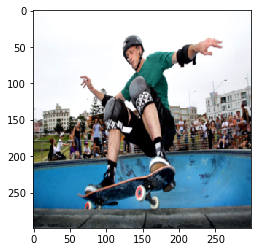

In [194]:
plt.imshow(img)

In [256]:
for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
-------
a skateboarder  on a skateboard  on  on 
a skateboarder  on a skateboard  on 
a skateboarder  on a skateboard  on 
a skateboarder  on a skateboard  on  on 
a man  on a skateboard  on 
a man  jumping  over 
a skateboarder  on a skateboard  on 


--2018-12-01 23:57:16--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Распознаётся ccanimalclinic.com (ccanimalclinic.com)… 23.185.0.2
Подключение к ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 106870 (104K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 104,37K   345KB/s    за 0,3s    

2018-12-01 23:57:17 (345 KB/s) - «data/img.jpg» сохранён [106870/106870]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


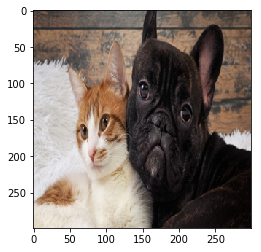

a cat is sitting on a couch with a laptop .
a cat sitting on a bed with a dog on the floor .
a cat is laying on a bed with a dog on it .
a cat sitting on a couch with a dog on the floor .
a cat laying on top of a bed .
a cat laying on a bed with a dog on it .
a cat is sitting on a couch with a dog .
-------
a cat  laying down  out  on 
a dog  sleeping  with 
a cat  sleeping  by 
a cat  laying on top of  by 
a cat  sleeping  by 
a cat  laying on top of  on 
a cat  laying on top of  out 


In [257]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

Как видно ранее, сеть, обученная на словаре bpe, справляется с составлением описаний гораздо хуже, нежели обычная сеть. Тем не менее, она также пытается выплёвывать что-то по теме, хоть это и мало похоже на natural language

Ниже я пытался привести примеры, когда сеть на bpe справляется лучше, нежели оригинальная сеть. Начал поиск слов, которых не было в обычном словаре, однако они были в bpe. Среди них оказалось слово 'masai'.

--2018-12-02 00:11:06--  http://www.orangesmile.com/extreme/img/main/masai_1.jpg
Распознаётся www.orangesmile.com (www.orangesmile.com)… 65.181.120.52
Подключение к www.orangesmile.com (www.orangesmile.com)|65.181.120.52|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 616622 (602K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 602,17K   464KB/s    за 1,3s    

2018-12-02 00:11:08 (464 KB/s) - «data/img.jpg» сохранён [616622/616622]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


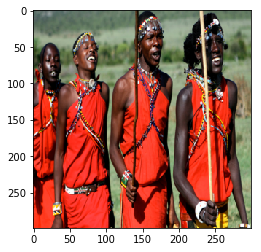

a group of people standing on a beach with a surfboard .
a group of people standing on a beach with a surfboard .
a group of people standing on a beach with a dog .
a group of people standing on a beach with a surfboard .
a group of people standing on a beach with a surfboard .
a group of people standing on a beach with a dog .
a group of people standing on a beach with a large dog .
-------
two  with  on  out 
a group of  with  on  in 
a group of  with  in  on 
a group of  with  on  out 
two  with  on  on  out 
a group of  with  on  out 
a group of  with  on  out 


In [265]:
!wget http://www.orangesmile.com/extreme/img/main/masai_1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))
    

Как мы видим, сеть на bpe не смогла выучить masai, в то время как обычная сеть по крайней мере распознала группу людей.
Далее я пытался найти картинку по тематике 'jamaica', однако, пример был неудачным для обеих сеток.

--2018-12-02 00:16:00--  http://anothercitizenship.com/wp-content/uploads/2016/06/jamaicaviza.jpg
Распознаётся anothercitizenship.com (anothercitizenship.com)… 91.239.234.96
Подключение к anothercitizenship.com (anothercitizenship.com)|91.239.234.96|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 119710 (117K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 116,90K   103KB/s    за 1,1s    

2018-12-02 00:16:02 (103 KB/s) - «data/img.jpg» сохранён [119710/119710]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


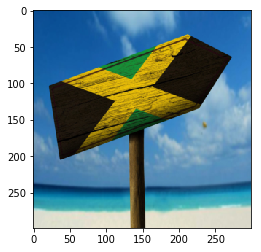

a person is riding a skateboard on a ramp .
a person is flying a kite on a skateboard .
a person is flying a kite on a skateboard .
a person is flying a kite on a skateboard .
a person with a blue and white shirt and a blue sky .
a person is riding a skateboard on a ramp .
a person is riding a skateboard on a ramp .
-------
the  out  out  from 
the  out  with  on 
two  sign  from  against 
two  out  out  out 
the  out  out  out 
the  out  out  against 
a stop sign  out  out  on 


In [266]:
!wget http://anothercitizenship.com/wp-content/uploads/2016/06/jamaicaviza.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))
    

Последняя попытка с редкими словами, слово 'microscope'. Возможно, достаточно глупо, так как слово microscope было использовано в каких-то узких контекстах, не являясь основной частью картинки.

--2018-12-02 00:29:16--  http://russia.shop-promoprices.com/950-1-large_default/5mp-%D0%BA%D0%BE%D0%BD%D1%84%D0%B8%D0%B3%D1%83%D1%80%D0%B0%D1%86%D0%B8%D1%8F-%D0%B2%D0%B5%D1%80%D1%85%D0%BD%D0%B5%D0%B3%D0%BE-%D1%83%D1%80%D0%BE%D0%B2%D0%BD%D1%8F-%D0%BC%D0%B5%D1%82%D0%B0%D0%BB%D0%BB%D0%BE%D0%B3%D1%80%D0%B0%D1%84%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5-%D1%82%D1%80%D0%B8%D0%BD%D0%BE%D0%BA%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B9-%D0%BC%D0%B5%D1%82%D0%B0%D0%BB%D0%BB%D1%83%D1%80%D0%B3%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9.jpg
Распознаётся russia.shop-promoprices.com (russia.shop-promoprices.com)… 104.18.34.133, 104.18.35.133
Подключение к russia.shop-promoprices.com (russia.shop-promoprices.com)|104.18.34.133|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg            [ <=>                ]  47,04K  --.-KB/s    за 0,07s   

2018-12-02 00:29:16 (715 KB/s) - «data/img.jpg» сохранён [481

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


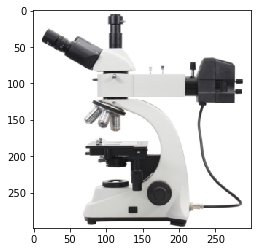

a white and white photo of a small bird
a white and white photo of a person in a red and white shirt .
a white and white picture of a small bird
a white and white photo of a person in a field .
a white and white bird with a bird on it
a white and white photo of a small bird
a red and white photo of a person on a street .
-------
two  are  with  are 
two  of  are  with 
two  with  on  on 
two  with  are  with 
two  are  are  with 
two  with  with  by 
the  with  are  under 


In [271]:
!wget http://russia.shop-promoprices.com/950-1-large_default/5mp-конфигурация-верхнего-уровня-металлографические-тринокулярный-металлургический.jpg  -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

Ниже я отчаялся продемонстрировать работу bpe сети, и просто начал смотреть разные картинки. Как оказалось, нормальная сеть не знает, что такое 'дерево'. А сеть на bpe очень хорошо знает, что такое 'поле' =)

--2018-12-02 00:31:44--  http://www.anypics.ru/mini/201210/12543.jpg
Распознаётся www.anypics.ru (www.anypics.ru)… 176.9.72.23
Подключение к www.anypics.ru (www.anypics.ru)|176.9.72.23|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 85410 (83K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>]  83,41K   384KB/s    за 0,2s    

2018-12-02 00:31:44 (384 KB/s) - «data/img.jpg» сохранён [85410/85410]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


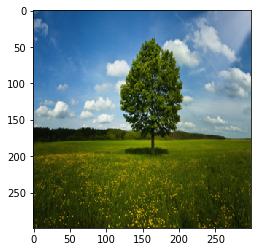

a field with a red and white dog in a field .
a field with a green and white fire hydrant .
a field with a red fire hydrant and a red fire hydrant .
a herd of sheep standing in a field .
a field with a green and white dog on a field .
a field with a green and white bird
a field with a green and white bird
-------
a field  in a field  in a field  in a field  in a field . 
a field  in a field  in a field  in a field .  in a field 
a field  in a field  in a field  in a field  in a field .  in a field . 
a field  in a field  in a field  in a field  in a field . 
a field  in a field  in a field  in a field  in a field . 
a field  in a field  out  in a field  in a field . 
a field  in a field  in a field  in a field .  in a field . 


In [272]:
!wget http://www.anypics.ru/mini/201210/12543.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

На картинку с автобусом сеть на bpe нагенерила описаний с 'a double decker bus', и тогда я задумал некоторую шалость (смотреть ниже)

--2018-12-02 00:35:03--  http://img4.tourbina.ru/photos.4/3/9/9/7/2/1427993/little.photo.jpg
Распознаётся img4.tourbina.ru (img4.tourbina.ru)… 77.247.241.22
Подключение к img4.tourbina.ru (img4.tourbina.ru)|77.247.241.22|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 24277 (24K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>]  23,71K  --.-KB/s    за 0,005s  

2018-12-02 00:35:03 (4,63 MB/s) - «data/img.jpg» сохранён [24277/24277]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


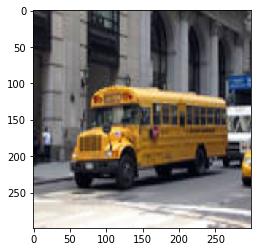

a bus is parked on the side of a road .
a bus driving down a street with a car and a car .
a bus is parked on the side of the road .
a red double decker bus is parked on the side of the road .
a double decker bus is parked on the side of the road .
a bus is parked on the side of the road .
a bus is parked on a street with a car .
-------
a double decker bus  traveling down  and  under 
a double decker bus  with  on  at 
two  with  on  by 
a double decker bus  with  at  on 
two  with  next to  under 
a double decker bus  with  near  under 
a double decker bus  at  on  under 


In [273]:
!wget http://img4.tourbina.ru/photos.4/3/9/9/7/2/1427993/little.photo.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

Вот на этом примере сеть на bpe даёт действительно более точное описание к картинке, нежели обычная сеть. 

--2018-12-02 00:36:31--  https://lingua-airlines.ru/wp-content/uploads/2017/02/Transport-London-2.jpg
Распознаётся lingua-airlines.ru (lingua-airlines.ru)… 54.72.20.247
Подключение к lingua-airlines.ru (lingua-airlines.ru)|54.72.20.247|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 164479 (161K) [image/jpeg]
Сохранение в: «data/img.jpg»

data/img.jpg        100%[===================>] 160,62K   633KB/s    за 0,3s    

2018-12-02 00:36:32 (633 KB/s) - «data/img.jpg» сохранён [164479/164479]



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


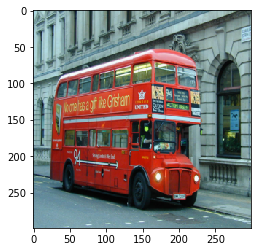

a bus driving down a street with a car parked on the side of the road .
a bus is parked on the side of the road .
a bus is parked on the side of a road .
a bus is parked on the side of a road .
a bus is parked on the side of a road .
a bus with a bus on the side of the road .
a bus is parked on the side of the road .
-------
a double decker bus  with  with  at 
a double decker bus  of  at 
a double decker bus  bus parked  with  at 
a double decker bus  parked  on 
a double decker bus  with  in front of  at 
a double decker bus  of  with 
a double decker bus  with  on a street . 


In [274]:
!wget https://lingua-airlines.ru/wp-content/uploads/2017/02/Transport-London-2.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(7):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))
print('-------')
for i in range(7):
    print(' '.join(generate_caption(img, t=5., type = 'bpe')[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563